In [76]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

In [77]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [92]:
#Obtain user input coordinates from Tracking Request page
input_lat = -33.96245606251111
input_long = 149.9673963028338

#Generate coordinates for a bounding box around the target
bbox_xmin = input_long - 0.0008
bbox_ymin = input_lat - 0.0008
bbox_xmax = input_long + 0.0008
bbox_ymax = input_lat + 0.0008

#Obtain user input time range from Tracking Request page
input_start = "2024-05-01"
input_end = "2024-12-31"

#Save bounding box and time range to a variable 
bbox_of_interest = [bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax]
time_of_interest = f"{input_start}/{input_end}"

In [93]:
#Obtain user input maximum cloud cover from Tracking Request page
input_cloud_cover = 0.1
input_cloud_cover = input_cloud_cover * 100

#Search current landsat level 2 data catalog for all images containing the specified bounding box, in the specified time period
#Returns only images from Landsat-8/landsat-9 below the maximum cloud cover threshold 
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
     query={
        "eo:cloud_cover": {"lt": input_cloud_cover},
        "platform": {"in": ["landsat-8", "landsat-9"]},
    },
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 9 Items


In [94]:
#Display most recent image from the results
selected_item = max(items, key=lambda item: item.datetime)

In [95]:

#selected_item = max(items, key=lambda item: eo.ext(item).datetime)

#print(
 #   f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
  #  + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
#)

In [96]:

max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [97]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset> Size: 620B
Dimensions:      (y: 7, x: 6)
Coordinates:
  * y            (y) float64 56B -3.762e+06 -3.762e+06 ... -3.762e+06 -3.762e+06
  * x            (x) float64 48B 7.741e+05 7.742e+05 ... 7.742e+05 7.743e+05
    spatial_ref  int32 4B 32655
    time         datetime64[ns] 8B 2024-08-30T23:50:04.264644
Data variables:
    nir08        (y, x) uint16 84B 14359 14187 14376 14488 ... 14750 15268 14796
    red          (y, x) uint16 84B 9053 8935 8942 8893 ... 9077 8829 8992 9056
    green        (y, x) uint16 84B 8686 8630 8637 8610 ... 8741 8521 8709 8756
    blue         (y, x) uint16 84B 8175 8175 8114 8113 ... 8114 8075 8158 8205
    qa_pixel     (y, x) uint16 84B 21824 21824 21824 21824 ... 21824 21824 21824
    lwir11       (y, x) uint16 84B 40683 40685 40706 40718 ... 40610 40657 40725

Text(0.5, 1.0, 'Natural Color Image')

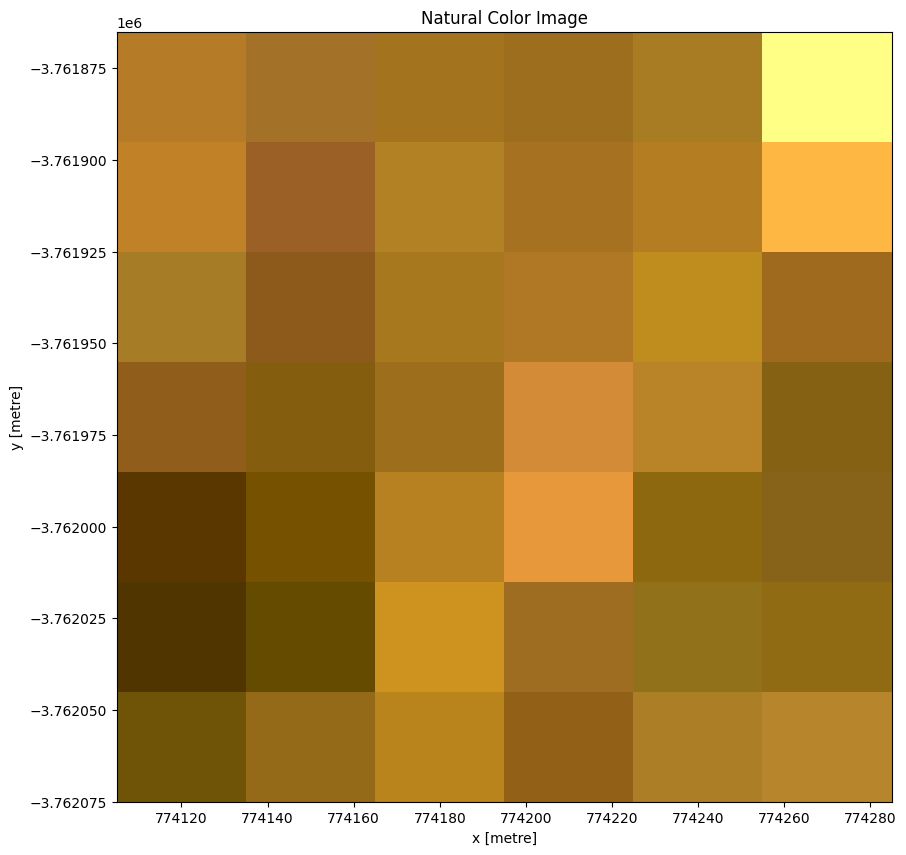

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))
data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color Image")

In [99]:
band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]

In [100]:
temperature = data["lwir11"].astype(float)
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:5, :5]

<xarray.DataArray 'lwir11' (y: 5, x: 5)> Size: 200B
array([[288.05530766, 288.0621437 , 288.13392212, 288.17493836,
        288.21253658],
       [288.27747896, 288.23646272, 287.99720132, 287.95618508,
        287.9766932 ],
       [288.31165916, 288.22620866, 287.98011122, 287.86048052,
        287.86389854],
       [288.39710966, 288.2330447 , 287.89807874, 287.75793992,
        287.78528408],
       [288.37318352, 288.18861044, 287.8741526 , 287.7374318 ,
        287.79553814]])
Coordinates:
  * y            (y) float64 40B -3.762e+06 -3.762e+06 ... -3.762e+06 -3.762e+06
  * x            (x) float64 40B 7.741e+05 7.742e+05 ... 7.742e+05 7.742e+05
    spatial_ref  int32 4B 32655
    time         datetime64[ns] 8B 2024-08-30T23:50:04.264644
Attributes:
    nodata:   0

Text(0.5, 1.0, 'Surface Temperature')

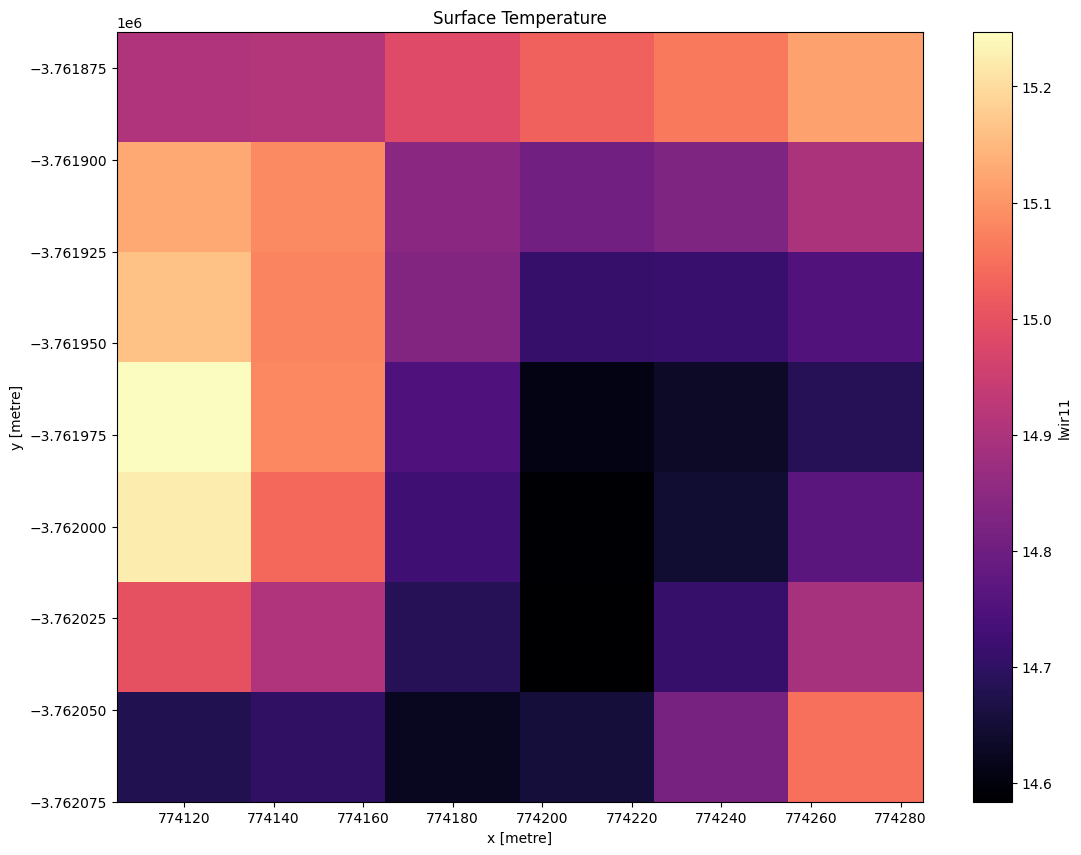

In [127]:
#Convert temperature from Kelvin to Celsius 
celsius = temperature - 273.15

#Plot surface temperature
fig, ax = plt.subplots(figsize=(13, 10))
celsius.plot.imshow(ax=ax, cmap="magma")
ax.set_title("Surface Temperature")


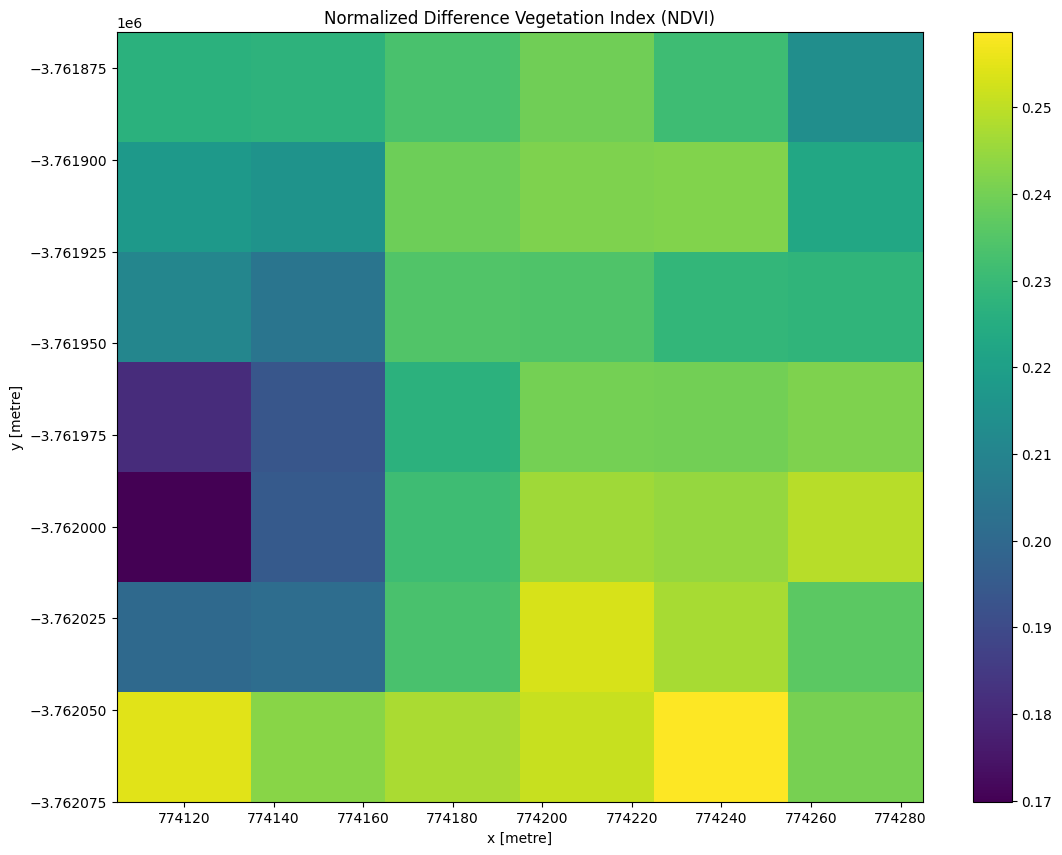

In [128]:
#Define bands needed to calculate NDVI
red = data["red"].astype("float")
nir = data["nir08"].astype("float")

#Calculate NDVI
ndvi = (nir - red) / (nir + red)

#Plot NDVI
fig, ax = plt.subplots(figsize=(13, 10))
ndvi.plot.imshow(ax=ax, cmap="viridis")
ax.set_title("Normalized Difference Vegetation Index (NDVI)");